<a href="https://colab.research.google.com/github/arnaudmkonan/Transformers-text-classification/blob/master/Transformers_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 31 05:04:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install -U transformers memory_profiler datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 441 kB 84.0 MB/s 
     |████████████████████████████████| 7.6 MB 57.2 MB/s 
     |████████████████████████████████| 163 kB 88.7 MB/s 
     |████████████████████████████████| 212 kB 89.5 MB/s 
     |████████████████████████████████| 115 kB 84.2 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
     |████████████████████████████████| 115 kB 68.4 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=02ef4ee086d9db6f5572a427f4c07f4757ab8deb332c474a0a227c7174d3678d
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successf

In [3]:
import torch, gc, random, datasets
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
%load_ext memory_profiler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [4]:
def set_seed(seed: int):
  random.seed(seed)
  np.random.seed(seed)
  if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)

  if is_tf_available():
      import tensorflow as tf
 
      tf.random.set_seed(seed)
 
set_seed(42)

In [5]:
df = pd.read_csv("https://github.com/AFAgarap/ecommerce-reviews-analysis/raw/master/Womens%20Clothing%20E-Commerce%20Reviews.csv")

In [6]:
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
# df['text_len'] = df['']

In [7]:
# print("Range:"+"("+str(df.total_score.min())+", "+str(df.total_score.max())+")")

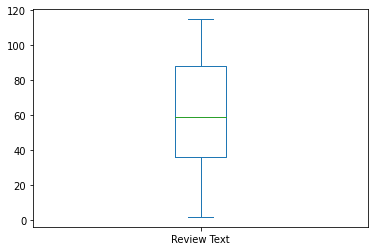

In [14]:
df['Review Text'].str.split(' ').str.len().plot(kind='box')

In [9]:
# df = df[~df.total_score.isna()]
# # df = df[~(df.score_1.isin(['0,0', '0,5', '1,0', '1,5', '2,0',]))]
# df = df[~(df.total_score.astype(float)==0)]

In [10]:
# len(df)

In [17]:
def LinearRegression_with_Transformer(model_name: str, 
                                      Data: pd.Series, 
                                      Target:pd.Series, 
                                      test_size: np.float64, 
                                      max_length: int, 
                                      num_labels: int, 
                                      num_epochs: int):

  # Make data
  X = Data
  y = Target


  # Split Data
  X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y, 
                                                      test_size=test_size)

  # Call the Tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # Encode the text
  train_encodings = tokenizer(X_train, truncation=True, padding=True, 
                              max_length=max_length)
  valid_encodings = tokenizer(X_test, truncation=True, padding=True, 
                              max_length=max_length)



  class MakeTorchData(torch.utils.data.Dataset):
      def __init__(self, encodings, labels):
          self.encodings = encodings
          self.labels = labels

      def __getitem__(self, idx):
          item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
          item["labels"] = torch.tensor([self.labels[idx]])
          item["labels"] = float(item["labels"])
          return item

      def __len__(self):
          return len(self.labels)

  # convert our tokenized data into a torch Dataset
  train_dataset = MakeTorchData(train_encodings, y_train.ravel())
  valid_dataset = MakeTorchData(valid_encodings, y_test.ravel())


  # Call Model
  model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                             num_labels = num_labels
                                                             ).to("cuda") # np.log(1000)

  # def inverse_sigmoid(logits):
  #   return -np.log((1.0 / (logits + 1e-8)) - 1.0)

  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import r2_score

  def compute_metrics_for_regression(eval_pred):
      logits, labels = eval_pred
      # print("Logits:", logits[0:5])
      # print("Labels:", labels[0:5])
      # logits = inverse_sigmoid(logits)
      labels = labels.reshape(-1, 1)
      
      print("Logits:", logits[0:5])
      print("Labels:", labels[0:5])
      # print("Labels:", labels)

      mse = mean_squared_error(labels, logits)
      rmse = mean_squared_error(labels, logits, squared=False)
      mae = mean_absolute_error(labels, logits)
      r2 = r2_score(labels, logits)
      # smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
      single_squared_errors = ((logits - labels).flatten()**2).tolist()
      accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / \
      len(single_squared_errors)
      
      return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "accuracy": accuracy}

  # Specifiy the arguments for the trainer  
  training_args = TrainingArguments(
      output_dir='./results',          # output directory
      num_train_epochs=num_epochs,     # total number of training epochs
      per_device_train_batch_size=64,   # batch size per device during training
      per_device_eval_batch_size=20,   # batch size for evaluation
      weight_decay=0.01,               # strength of weight decay
      learning_rate=2e-5,
      # logging_dir='./logs',            # directory for storing logs
      save_total_limit=10,
      load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
      metric_for_best_model = 'accuracy',    # select the base metrics
      evaluation_strategy="epoch",
      save_strategy="epoch",
  ) 

  # Call the Trainer
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=valid_dataset,          # evaluation dataset
      compute_metrics=compute_metrics_for_regression,     # the callback that computes metrics of interest
  )

  # Train the model
  trainer.train()
  
  # Call the summary
  trainer.evaluate()



  return trainer, model

In [19]:
# %%time
# %%memit
# bert_trainer, bert_model = LinearRegression_with_Transformer(
#     model_name = 'neuralmind/bert-large-portuguese-cased', 
#     Data = df.essay_text.astype(str), 
#     Target = df.total_score.astype(float), 
#     test_size = 0.2, 
#     max_length = 512, 
#     num_labels = 1, 
#     num_epochs = 100)

In [20]:
df2 = df[3000:].copy()
df3 = df[0:3000].copy()

In [21]:
%%time
%%memit
sbert_trainer, sbert_model = LinearRegression_with_Transformer(model_name = 'bert-base-uncased', 
                                                                 Data = df2['Review Text'].astype(str), 
                                                                 Target = df2.Rating.astype(float), 
                                                                 test_size = 0.66, 
                                                                 max_length = 126, 
                                                                 num_labels = 1, 
                                                                 num_epochs = 5)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Accuracy
1,No log,0.500524,0.500524,0.707478,0.466940,0.587530,0.651727
2,No log,0.418156,0.418156,0.646650,0.448594,0.655407,0.659788
3,No log,0.459662,0.459662,0.677984,0.448860,0.621203,0.669699
4,No log,0.437063,0.437063,0.661107,0.440749,0.639827,0.669551
5,0.833500,0.444575,0.444575,0.666764,0.446264,0.633637,0.668146


***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.0179012]
 [4.963954 ]
 [4.3650155]
 [5.0826354]
 [4.927092 ]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]


Saving model checkpoint to ./results/checkpoint-109
Configuration saved in ./results/checkpoint-109/config.json
Model weights saved in ./results/checkpoint-109/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.3290854]
 [4.7873936]
 [4.448004 ]
 [4.8959966]
 [4.641625 ]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]


Saving model checkpoint to ./results/checkpoint-218
Configuration saved in ./results/checkpoint-218/config.json
Model weights saved in ./results/checkpoint-218/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.592906 ]
 [4.9893417]
 [4.9546757]
 [5.088162 ]
 [4.959184 ]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]


Saving model checkpoint to ./results/checkpoint-327
Configuration saved in ./results/checkpoint-327/config.json
Model weights saved in ./results/checkpoint-327/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.451768 ]
 [4.9557514]
 [4.878191 ]
 [5.068878 ]
 [4.7145414]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]


Saving model checkpoint to ./results/checkpoint-436
Configuration saved in ./results/checkpoint-436/config.json
Model weights saved in ./results/checkpoint-436/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.5204988]
 [4.9695716]
 [4.893652 ]
 [5.0832076]
 [4.7680836]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]


Saving model checkpoint to ./results/checkpoint-545
Configuration saved in ./results/checkpoint-545/config.json
Model weights saved in ./results/checkpoint-545/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-327 (score: 0.6696989867613342).
***** Running Evaluation *****
  Num examples = 13521
  Batch size = 20


Logits: [[3.592906 ]
 [4.9893417]
 [4.9546757]
 [5.088162 ]
 [4.959184 ]]
Labels: [[2.]
 [5.]
 [5.]
 [4.]
 [4.]]
peak memory: 4321.50 MiB, increment: 3469.61 MiB
CPU times: user 19min 35s, sys: 1min 39s, total: 21min 15s
Wall time: 21min 17s


In [22]:
class MakeTorchData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        item["labels"] = float(item["labels"])
        return item

    def __len__(self):
        return len(self.labels)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_embeddings = tokenizer(df3['Review Text'].astype(str).tolist(), truncation=True, padding=True, max_length=126)
test_dataset = MakeTorchData(test_embeddings, df3.Rating.astype(float))

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/5546055f03398095e385d7dc625e636cc8910bf2/vocab.txt
loading file to

In [23]:
sbert_trainer.eval_dataset = test_dataset
sbert_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3000
  Batch size = 20


Logits: [[5.1638246]
 [5.212413 ]
 [2.9011767]
 [5.1636147]
 [5.184988 ]]
Labels: [[4.]
 [5.]
 [3.]
 [5.]
 [5.]]


{'eval_loss': 0.4853343069553375,
 'eval_mse': 0.4853343069553375,
 'eval_rmse': 0.6966593861579895,
 'eval_mae': 0.460431307554245,
 'eval_r2': 0.6127650348589968,
 'eval_accuracy': 0.6593333333333333,
 'eval_runtime': 20.4929,
 'eval_samples_per_second': 146.392,
 'eval_steps_per_second': 7.32,
 'epoch': 5.0}